# Project 4: Advanced Lane Lines

In [1]:
# Import libraries

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

# P4 lib
from p4lib.calibration import Calibration
from p4lib.perspective import Perspective
from p4lib.lane_detection import LaneDetectionSW
from p4lib import filters
from p4lib import utils
from p4lib.diag_tools import DiagWindow

# video processing
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

In [2]:
# Global variables and flags
cal_dir = 'camera_cal'
cal_file = 'cal.p'
test_dir = 'test_images'

# Others
debug = False

## Correct for distortion (Calibrate camera and undistort images)

In [3]:
cal = Calibration(cal_dir, cal_file)

## Gradient Threshold

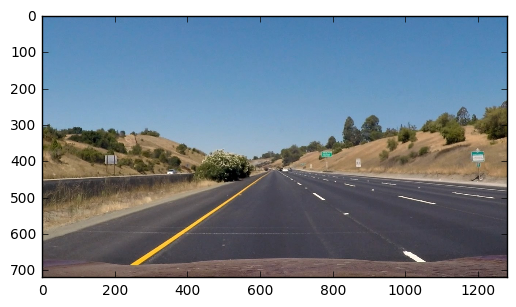

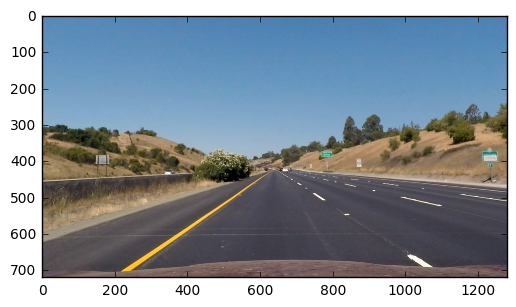

True

In [4]:
# Apply thresholds and detect lanes on a simple image

test_images = ["straight_lines1", "straight_lines2", "test1", "test2", "test3", "test4", "test5", "test6"]

lanes = cv2.imread(os.path.join(test_dir, test_images[0] + '.jpg'))

lanes = cv2.cvtColor(lanes, cv2.COLOR_BGR2RGB)
plt.imshow(lanes)
plt.show()

undst_lanes = cal.undistort(lanes)
plt.imshow(undst_lanes)
plt.show()

cv2.imwrite('/tmp/undistorted.jpg', cv2.cvtColor(undst_lanes, cv2.COLOR_BGR2RGB))

### Sobel

In [5]:
gradx = filters.abs_sobel_thresh(lanes, orient='x', sobel_kernel=9, thresh=(20, 100))
grady = filters.abs_sobel_thresh(lanes, orient='y', sobel_kernel=9, thresh=(20, 100))

### Magnitude of the Gradient

In [6]:
mag_binary = filters.mag_thresh(lanes, sobel_kernel=9, mag_thresh=(30, 100))

### Direction of the Gradient

In [7]:
dir_binary = filters.dir_threshold(lanes, sobel_kernel=9, thresh=(0.7, 1.3))

### Combine all the thresholds

In [8]:
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

## Color Threshold

In [9]:
hsv = cv2.cvtColor(lanes, cv2.COLOR_RGB2HSV)

H = hsv[:,:,0]
S = hsv[:,:,1]
V = hsv[:,:,2]

Apply threshold

In [10]:
low_threshold = np.array([0, 0, 225])
high_threshold = np.array([255, 255, 255])

# Filter yellow lane
yellow_hsv_low  = np.array([ 0, 80, 200])
yellow_hsv_high = np.array([ 40, 255, 255])
yellow_filter = cv2.inRange(hsv, yellow_hsv_low, yellow_hsv_high)

# Filter white lane
white_hsv_low  = np.array([  20,   0,   200])
white_hsv_high = np.array([ 255,  80, 255])
white_filter = cv2.inRange(hsv, white_hsv_low, white_hsv_high)

# Fuse both filters
mask = np.zeros_like(yellow_filter)
mask[(yellow_filter > 0) | (white_filter > 0)] = 1

# Apply mask
hsv_binary = cv2.bitwise_and(lanes, lanes, mask=mask)
hsv_binary = hsv_binary[:, :, 0]
hsv_binary[hsv_binary > 0] = 1

# Dilate the selected region
kernel = np.ones((3, 3), np.uint8)
hsv_binary = cv2.dilate(hsv_binary, kernel, iterations = 2)

In [11]:
# Combine all thresholds
gradient = np.zeros_like(H)
magnitude = np.zeros_like(H)
combined_binary = np.zeros_like(H)

#gradient[((gradx == 1) & (grady == 1))] = 1
#magnitude[((mag_binary == 1) & (dir_binary == 1))] = 1
#magnitude[(mag_binary == 1)] = 1

# R: gradient
# G: magnitude
# B: HSV threshold
color_binary = np.dstack((gradient, magnitude, hsv_binary))
color_binary = np.uint8(255 * color_binary)

combined_binary[(gradient == 1) | (magnitude == 1) | (hsv_binary == 1)] = 1
#combined_binary[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

## Perspective transform (bird-eye)

In [12]:
y = lanes.shape[0]
x = lanes.shape[1]
orig_img_size = (x, y)

# Src points
src = np.float32([[int(0.446 * x), int(0.645 * y)],
                  [int(0.554 * x), int(0.645 * y)],
                  [int(0.872 * x), y],
                  [int(0.150 * x), y]])


ym_per_pix = 30  / 720 # meters per pixel in y dimension
xm_per_pix = 3.7 / 700 # meteres per pixel in x dimension

# Perspective size is 5.55 (3.7 lane + 0.925 at each side) meters width and 25 meters height
y = int(25 / ym_per_pix)
width = int(3.7 / xm_per_pix)
offset = int(width / 4)
x = 2 * offset + width
img_size = (x, y)

# Dst points
dst = np.float32([[offset, 0],
                  [x - offset, 0],
                  [x - offset, y],
                  [offset, y]])

birds_eye = Perspective(src, dst, orig_img_size, img_size)

In [16]:
window = DiagWindow()
sliding_window_lanes = LaneDetectionSW(debug_img=True)

def debug_pipeline(img):
    global window
    global left_lane
    global right_lane

    # Pipeline
    img = cal.undistort(img)
    warped = birds_eye.warp(img)
    gradx = filters.abs_sobel_thresh(img, orient='x', sobel_kernel=9, thresh=(20, 100))
    grady = filters.abs_sobel_thresh(img, orient='y', sobel_kernel=9, thresh=(20, 100))
    mag_binary = filters.mag_thresh(img, sobel_kernel=9, mag_thresh=(30, 100))
    dir_binary = filters.dir_threshold(img, sobel_kernel=9, thresh=(0.7, 1.3))
    comb = np.zeros_like(gradx)
    comb[(gradx == 1) & (grady == 1)] = 1 

    yellow_hsv_low  = np.array([0, 80, 200])
    yellow_hsv_high = np.array([40, 255, 255])
    white_hsv_low  = np.array([20, 0, 200])
    white_hsv_high = np.array([255, 80, 255])
    yellow = filters.hsv_range(img, yellow_hsv_low, yellow_hsv_high)
    white = filters.hsv_range(img, white_hsv_low, white_hsv_high)

    final = np.zeros_like(gradx)
    final[(comb == 1) | (yellow == 1) | (white == 1)] = 1
    final = birds_eye.warp(final)

    sliding_window_lanes.process(final)
    detection_debug = sliding_window_lanes.get_debug_img()
    left_lane, right_lane = sliding_window_lanes.get_lanes()
    lanes_drawn_unwarped, lanes_drawn = utils.draw_lanes(img, final, {'left': left_lane, 'right': right_lane}, birds_eye)

    left_curvature, right_curvature = sliding_window_lanes.get_curvature()
    avg_curvature = (left_curvature + right_curvature) / 2

    offset = sliding_window_lanes.get_offset()

    # Debugging
    window.set_region('main', lanes_drawn)
    window.set_region('second', detection_debug)
    window.set_region('t1', warped)
    window.set_region('t2', final)
    window.set_region('t3', birds_eye.warp(comb))
    window.set_region('t4', lanes_drawn_unwarped)
    window.set_region('b1', birds_eye.warp(gradx))
    window.set_region('b2', birds_eye.warp(grady))
    window.set_region('b3', birds_eye.warp(mag_binary))
    window.set_region('b4', birds_eye.warp(dir_binary))
    window.set_region('text', ['Curvature - AVG: {:.2f}m, Left: {:.2f}m, Right: {:.2f}m'.format(avg_curvature, left_curvature, right_curvature), 'Offset: {:.2f}cm'.format(offset*100)])

    return window.get_output()

def pipeline(img):
    return img

In [17]:
project_output = ''
if True:
    project_output = 'project_video_output_pipeline.mp4'
    clip = VideoFileClip('project_video.mp4');
    project_clip = clip.fl_image(debug_pipeline) #NOTE: this function expects color images!!
    %time project_clip.write_videofile(project_output, audio=False);
else:
    plt.imshow(debug_pipeline(lanes))
    plt.show()

[MoviePy] >>>> Building video project_video_output_pipeline.mp4
[MoviePy] Writing video project_video_output_pipeline.mp4


100%|█████████▉| 1260/1261 [10:26<00:00,  2.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_pipeline.mp4 

CPU times: user 15min 23s, sys: 50.8 s, total: 16min 14s
Wall time: 10min 29s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))